# Лабораторная на Регрессию ||

В ходе этой работы мы проведём регрессию на реальных данных при помощи линейной регрессии

## Импортируем библиотеки

In [60]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

## Получим данные и кратко посмотрим на них

In [61]:
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
# Добавим целевой признак
df['Price'] = california.target

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      5

Данных много, признаков хватает, при этом нет пустых значений (меньше обрабатывать)

## Проведём визуализацию данных

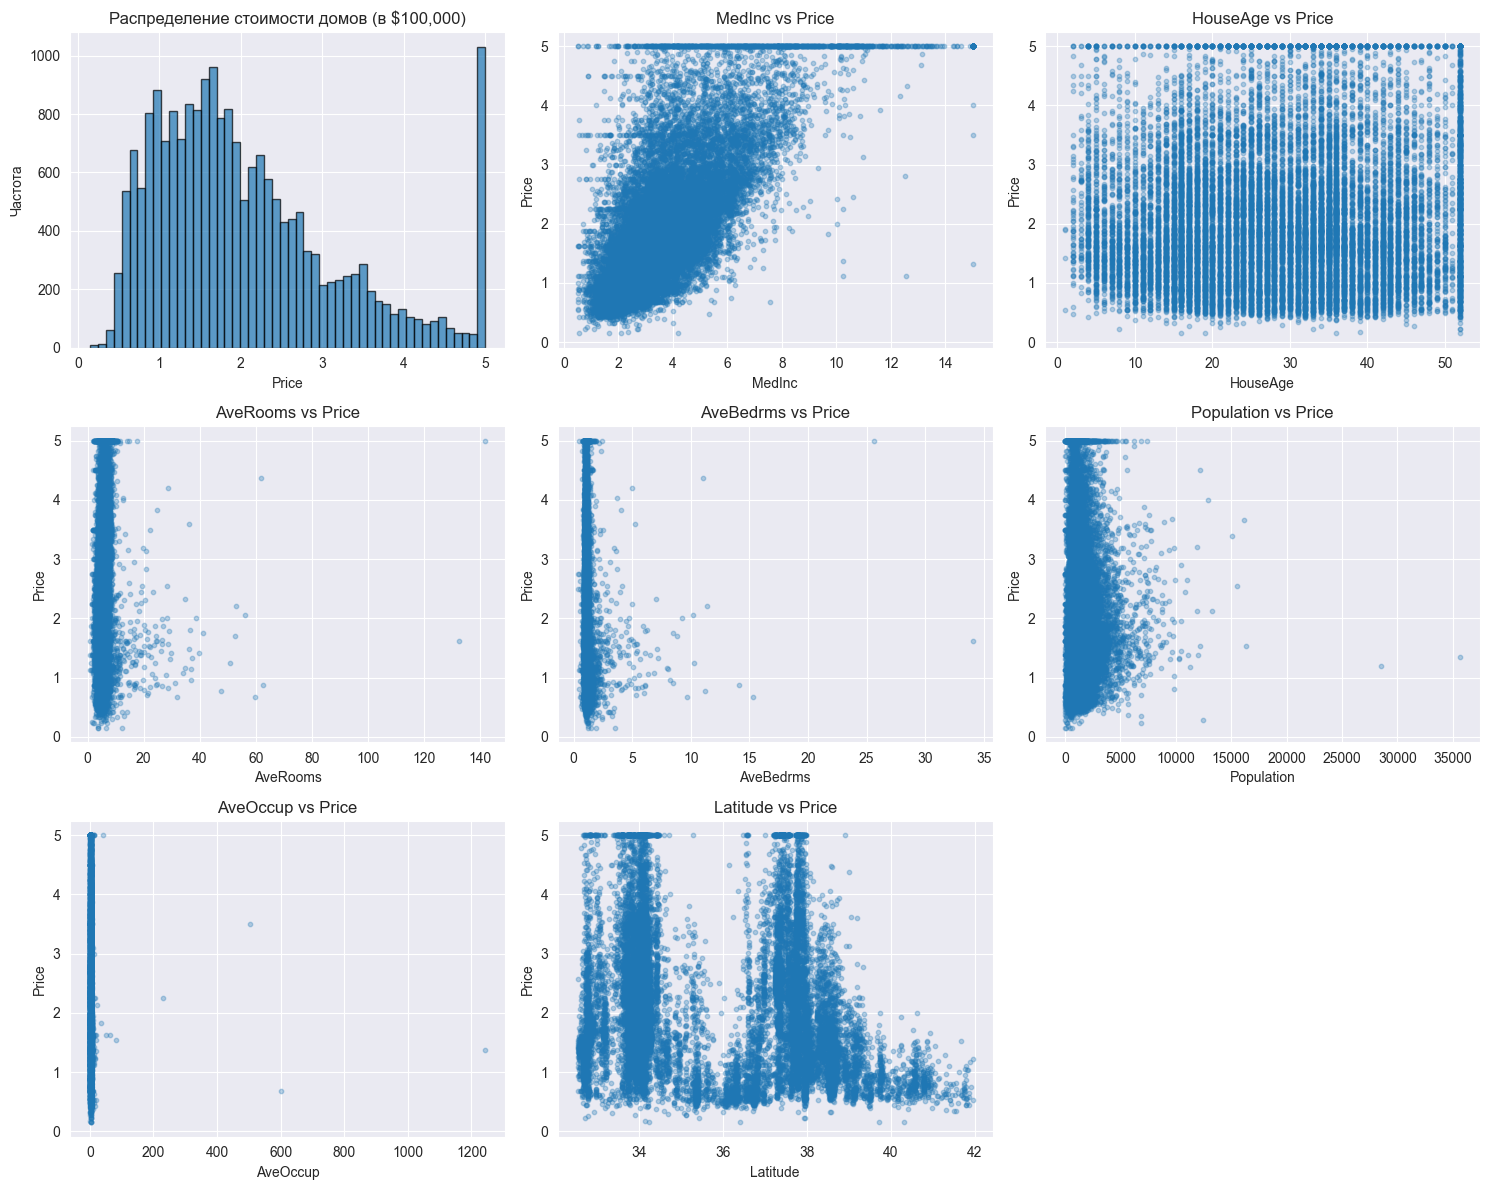

In [62]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

axes[0].hist(df['Price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение стоимости домов (в $100,000)')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Частота')

for i, feature in enumerate(california.feature_names[:8], 1):
    axes[i].scatter(df[feature], df['Price'], alpha=0.3, s=10)
    axes[i].set_title(f'{feature} vs Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')

fig.delaxes(axes[8])

plt.tight_layout()
plt.show()

Здесь мы видим, что данные не идеальны и мы должны их править. Займёмся этим

## Проведём адекватную предварительную обработку данных

In [63]:
# Разделим на признаки и целевую
X = df.drop('Price', axis=1)
y = df['Price']

# Разделим на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Стандартизируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучим базовую модель линейной регрессии

In [64]:
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_model.predict(X_test_scaled)

print(f"R²: {r2_score(y_test, y_pred_baseline):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_baseline)*100000:.0f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_baseline))*100000:.0f}")

R²: 0.5758
MAE: 53320
RMSE: 74558


Метрики вышли не очень, но уже есть от чего отталкиваться

## Попытаемся улучшить качество модели с помощью полиномов (их явно не хватает)

In [65]:
from sklearn.preprocessing import PolynomialFeatures

degrees = [1, 2, 3, 4, 5]
results = []

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    scaler = StandardScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_test_poly_scaled = scaler.transform(X_test_poly)

    model = LinearRegression()
    model.fit(X_train_poly_scaled, y_train)

    y_pred = model.predict(X_test_poly_scaled)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred) * 100000
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) * 100000

    y_pred_train = model.predict(X_train_poly_scaled)
    train_r2 = r2_score(y_train, y_pred_train)

    results.append({
        'degree': degree,
        'r2': r2,
        'train_r2': train_r2,
        'rmse': rmse,
        'model': model,
        'n_features': X_train_poly.shape[1]
    })

    print(f"\nDegree {degree}:")
    print(f"  R² train: {train_r2:.4f}")
    print(f"  R² test:  {r2:.4f}")
    print(f"  RMSE:     ${rmse:.0f}")
    print(f"  Features: {X_train_poly.shape[1]}")

best_idx = np.argmax([r['r2'] for r in results])
best = results[best_idx]

print(f"ЛУЧШИЙ РЕЗУЛЬТАТ: Degree {best['degree']}")
print(f"R² test:  {best['r2']:.4f}")
print(f"R² train: {best['train_r2']:.4f}")
print(f"Разница:  {best['train_r2'] - best['r2']:.4f} (переобучение)")
print(f"RMSE:     ${best['rmse']:.0f}")
print(f"Кол-во признаков: {best['n_features']}")

print(f"\nУлучшение относительно baseline:")
baseline_r2 = r2_score(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline)) * 100000

print(f"diff R²:    {best['r2'] - baseline_r2:+.4f}")
print(f"diff RMSE: -${baseline_rmse - best['rmse']:.0f}")
print(f"Улучшение R²: {(best['r2'] - baseline_r2)/abs(baseline_r2)*100:.1f}%")



Degree 1:
  R² train: 0.6126
  R² test:  0.5758
  RMSE:     $74558
  Features: 8

Degree 2:
  R² train: 0.6853
  R² test:  0.6457
  RMSE:     $68140
  Features: 44

Degree 3:
  R² train: 0.7441
  R² test:  -18.3887
  RMSE:     $504055
  Features: 164

Degree 4:
  R² train: 0.7893
  R² test:  -11476.1042
  RMSE:     $12263646
  Features: 494

Degree 5:
  R² train: 0.8254
  R² test:  -17569855.1549
  RMSE:     $479830150
  Features: 1286
ЛУЧШИЙ РЕЗУЛЬТАТ: Degree 2
R² test:  0.6457
R² train: 0.6853
Разница:  0.0396 (переобучение)
RMSE:     $68140
Кол-во признаков: 44

Улучшение относительно baseline:
diff R²:    +0.0699
diff RMSE: -$6418
Улучшение R²: 12.1%


Благодаря использованию полиномов мы улучшили модель и не переобучили

## Вывод (серединный)
В ходе работы мы обучили модельку, немного поигрались с полиномами и выбрали лучший. В целом вышла модель выше 50% по всем метрикам, что уже лучше Base Line

## Давайте теперь поработаем с другой моделью и сравним метрики

Возьмём Дерево Решений

Создадим базовое дерево, обучим на всех данных и посмотрим метрики

In [66]:
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train_scaled, y_train)

y_pred_tree = tree_model.predict(X_test_scaled)

tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
tree_r2 = r2_score(y_test, y_pred_tree)

print(f"RMSE: ${tree_rmse*100000:.0f}")
print(f"R²: {tree_r2:.4f}")

RMSE: $64424
R²: 0.6833


Вышло даже лучше линейной регрессии с полиномами, но теперь нужно поиграться с параметрами, чтобы улучшить наши метрики

In [67]:
best_score = -float('inf')
best_depth = None

for depth in [3, 5, 8, 10, 12, 15, 20, 30, 40, None]:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train_scaled, y_train)

    y_pred = tree.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)

    if r2 > best_score:
        best_score = r2
        best_depth = depth

    print(f"depth={depth}: R²={r2:.4f}")

print(f"\nЛучшая глубина: {best_depth}, R²: {best_score:.4f}")

final_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
final_tree.fit(X_train_scaled, y_train)

y_pred_final = final_tree.predict(X_test_scaled)

final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final)) * 100000

print(f"\nФинальное дерево:")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: ${final_rmse:.0f}")

depth=3: R²=0.5098
depth=5: R²=0.5997
depth=8: R²=0.6779
depth=10: R²=0.6833
depth=12: R²=0.6687
depth=15: R²=0.6465
depth=20: R²=0.6275
depth=30: R²=0.6199
depth=40: R²=0.6230
depth=None: R²=0.6230

Лучшая глубина: 10, R²: 0.6833

Финальное дерево:
R²: 0.6833
RMSE: $64424


Вышло так, что именно глубина 10 оказалась лучшей (по признаку R2), те наша базовая модель

## Вывод (финальный по сравнению 2 разных моделей классификации)
В ходе работы мы обучили 2 разные по типу модели, а так же улучшили их. Увидели, что для наших данных дерево решений оказалось чуть лучше, но не критично. Скорее всего была плохо проведена предобработка данных, а так же плохая работа с признаками. В ходе работы научились делать регресс и уже хорошо